In [1]:
# _*_ coding: utf-8 _*_

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()  #交互模式 

In [3]:
#训练集上的数据增强及归一化，验证集上的归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]
    ),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]
    ),
}

data_dir = 'data/hymenoptera_data'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val'] }
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle=True, num_workers=4)
               for x in ['train', 'val']
              }
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val'] }
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


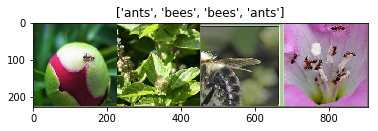

In [8]:
#显示一些样本图片
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)   #pause a bit so that plots are updated

#Get a batch of training data 
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x]  for x in classes])

In [24]:
#Scheduling the learning rate
#Saving the best model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('_' * 10)
        
        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  #Set model to training mode
            else:
                model.eval()   #Set model to evaluate mode
            
            running_loss     = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero  the paramer gradients
                optimizer.zero_grad()
                
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #统计
                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            
            epoch_loss  = running_loss / dataset_sizes[phase]
            epoch_acc   = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc :
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [30]:
#Generic function to display predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
#加载预训练模型，然后重设最后的全连接层

model_ft = models.resnet18(pretrained=True)  #18层resnet预训练网络加载
num_ftrs = model_ft.fc.in_features  #参数数量
model_ft.fc = nn.Linear(num_ftrs, 2) #重新定义fc层，此时，会进行参数的更新

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that all paraameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr =0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch0/24
__________
train loss: 0.5084 Acc: 0.7459
val loss: 0.2368 Acc: 0.9020

Epoch1/24
__________
train loss: 0.5908 Acc: 0.7664
val loss: 0.2467 Acc: 0.9085

Epoch2/24
__________
train loss: 0.4426 Acc: 0.8197
val loss: 0.2921 Acc: 0.8824

Epoch3/24
__________
train loss: 0.4336 Acc: 0.8443
val loss: 0.3733 Acc: 0.8497

Epoch4/24
__________
train loss: 0.4837 Acc: 0.8074
val loss: 0.4243 Acc: 0.8170

Epoch5/24
__________
train loss: 0.4681 Acc: 0.8238
val loss: 0.7037 Acc: 0.7647

Epoch6/24
__________
train loss: 0.4430 Acc: 0.8238
val loss: 0.3900 Acc: 0.8562

Epoch7/24
__________
train loss: 0.2640 Acc: 0.8852
val loss: 0.2691 Acc: 0.8824

Epoch8/24
__________
train loss: 0.4237 Acc: 0.8402
val loss: 0.2708 Acc: 0.8889

Epoch9/24
__________
train loss: 0.3351 Acc: 0.8402
val loss: 0.2511 Acc: 0.8954

Epoch10/24
__________
train loss: 0.3431 Acc: 0.8525
val loss: 0.2506 Acc: 0.8954

Epoch11/24
__________
train loss: 0.3762 Acc: 0.8443
val loss: 0.2318 Acc: 0.9150

Epoch12/24
___

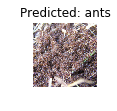

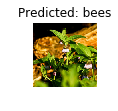

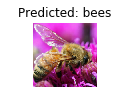

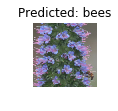

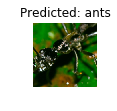

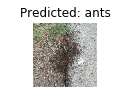

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [35]:
visualize_model(model_ft)
#打印模型
print(model_ft)

In [33]:
#ConvNet as fixed feature extractor
#此例中，我们仅改变网络最后一层，其它层保持不动
#通过设置requires_grad == False 来保证网络层不改变，反向传播时不会计算梯度

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requored_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) #重新定义fc层，此时，会进行参数的更新

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

#Observe that all paraameters are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr =0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#Train and evaluate
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch0/24
__________
train loss: 0.5981 Acc: 0.6803
val loss: 0.2128 Acc: 0.9412

Epoch1/24
__________
train loss: 0.4265 Acc: 0.8361
val loss: 0.3709 Acc: 0.8431

Epoch2/24
__________
train loss: 0.4515 Acc: 0.8115
val loss: 0.3698 Acc: 0.8431

Epoch3/24
__________
train loss: 0.5163 Acc: 0.7787
val loss: 0.2094 Acc: 0.9346

Epoch4/24
__________
train loss: 0.4980 Acc: 0.7869
val loss: 0.1699 Acc: 0.9477

Epoch5/24
__________
train loss: 0.4152 Acc: 0.7992
val loss: 0.2931 Acc: 0.8954

Epoch6/24
__________
train loss: 0.4593 Acc: 0.8115
val loss: 0.2437 Acc: 0.9412

Epoch7/24
__________
train loss: 0.3768 Acc: 0.8279
val loss: 0.2430 Acc: 0.9150

Epoch8/24
__________
train loss: 0.2911 Acc: 0.8689
val loss: 0.1754 Acc: 0.9477

Epoch9/24
__________
train loss: 0.3350 Acc: 0.8607
val loss: 0.2166 Acc: 0.9346

Epoch10/24
__________
train loss: 0.3505 Acc: 0.8402
val loss: 0.1943 Acc: 0.9412

Epoch11/24
__________
train loss: 0.2980 Acc: 0.8770
val loss: 0.1751 Acc: 0.9542

Epoch12/24
___

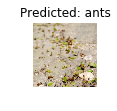

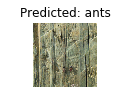

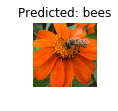

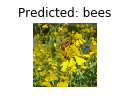

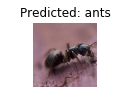

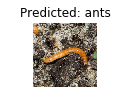

In [34]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [37]:
#保存模型参数
torch.save(model_conv.state_dict(), './model_conv')